In [1]:
import matplotlib
matplotlib.use('Agg')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Helpers
import sys
sys.path.insert(0,'../../')
from helpers import *
from scipy.sparse import csr_matrix,save_npz,load_npz
from sklearn.model_selection import cross_val_score,LeaveOneOut,StratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,log_loss
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold
import pickle

# Algorithms
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [31]:
data_path = '../data/'
# train_X, train_y, test_X ,test_y = load_data('v1','bin')
train_X = load_npz(data_path + 'X_sparse/'+ 'train_bin.npz')
test_X = load_npz(data_path + 'X_sparse/'+ 'test_bin.npz')

train_y = pd.read_csv(data_path + 'train_Y.csv')
test_y = pd.read_csv(data_path + 'test_Y.csv')

# with open(data_path + 'TCRs_ranking_ind_pos.pkl', 'rb') as f:
#     TCRs_ind = pickle.load(f)

p_values_origin = pd.read_pickle('../data/inc_p_values.pkl')

# kept_TCRs = p_values_origin[TCRs[p_values_origin.loc['p_value']<=1e-4]].columns.values
kept_TCRs = p_values_origin.T[p_values_origin.T['p_value']<=1e-4].T.columns.values
indices = [p_values_origin.columns.get_loc(col) for col in kept_TCRs]

sub_train_X = train_X[:,indices].toarray()
sub_train_df = pd.DataFrame(sub_train_X,columns=kept_TCRs)
sub_train_df.insert(0,'sample_name',train_y['sample_name'])
sub_train_df = pd.merge(train_y,sub_train_df)

sub_test_X = test_X[:,indices].toarray()
sub_test_df = pd.DataFrame(sub_test_X,columns=kept_TCRs)
sub_test_df.insert(0,'sample_name',test_y['sample_name'])
sub_test_df = pd.merge(test_y,sub_test_df)

sub_train_df.to_pickle('../data/feature_engineering/sub_train_bin.pkl')
sub_test_df.to_pickle('../data/feature_engineering/sub_test_bin.pkl')

In [38]:
train_X = load_npz(data_path + 'X_sparse/'+ 'train_count.npz')
test_X = load_npz(data_path + 'X_sparse/'+ 'test_count.npz')

sub_train_X = train_X[:,indices].toarray()
sub_train_df = pd.DataFrame(sub_train_X,columns=kept_TCRs)
sub_train_df.insert(0,'sample_name',train_y['sample_name'])
sub_train_df = pd.merge(train_y,sub_train_df)

sub_test_X = test_X[:,indices].toarray()
sub_test_df = pd.DataFrame(sub_test_X,columns=kept_TCRs)
sub_test_df.insert(0,'sample_name',test_y['sample_name'])
sub_test_df = pd.merge(test_y,sub_test_df)

sub_train_df.to_pickle('../data/feature_engineering/sub_train_count.pkl')
sub_test_df.to_pickle('../data/feature_engineering/sub_test_count.pkl')

In [42]:
train_X = load_npz(data_path + 'X_sparse/'+ 'train_freq.npz')
test_X = load_npz(data_path + 'X_sparse/'+ 'test_freq.npz')

sub_train_X = train_X[:,indices].toarray()
sub_train_df = pd.DataFrame(sub_train_X,columns=kept_TCRs)
sub_train_df.insert(0,'sample_name',train_y['sample_name'])
sub_train_df = pd.merge(train_y,sub_train_df)

sub_test_X = test_X[:,indices].toarray()
sub_test_df = pd.DataFrame(sub_test_X,columns=kept_TCRs)
sub_test_df.insert(0,'sample_name',test_y['sample_name'])
sub_test_df = pd.merge(test_y,sub_test_df)

sub_train_df.to_pickle('../data/feature_engineering/sub_train_freq.pkl')
sub_test_df.to_pickle('../data/feature_engineering/sub_test_freq.pkl')

Optimal number of features : 163
AUROC: 0.8698493890309746 Accuracy:  0.7833333333333333


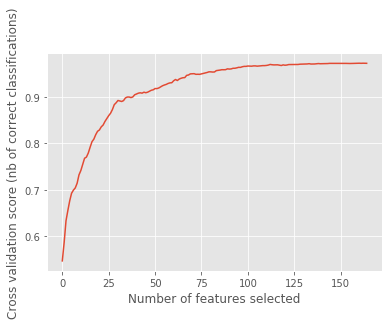

In [17]:

# Define a classifier

rfecv = a(clf,cv=StratifiedKFold(20,random_state=0),scoring='roc_auc',step = 1)
rfecv.fit(sub_train_X,train_y['phenotype_status'])

print("Optimal number of features : %d" % rfecv.n_features_)

print('AUROC:',roc_auc_score(test_y['phenotype_status'],rfecv.predict_proba(test_X[:,indices])[:,1]),'Accuracy: ',accuracy_score(test_y['phenotype_status'],
        rfecv.predict(test_X[:,indices])))

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

In [33]:
num = [160]
for n in num:
    kf = LeaveOneOut()
    for train_index,test_index in kf.split(train_y): # for each cv round
        train_cv = train_y.iloc[train_index]
        test_cv = train_y.iloc[test_index]
        test_sample = test_cv['sample_name'].values[0]
        print('Cross validation test sample:',test_sample)
        p_values_df = pd.read_pickle('../data/LOO_p_values/'+test_sample+'.pkl')
        kept_TCRs = p_values_df.T.nsmallest(n,'p_value').T.columns.values
        indices = [p_values_origin.columns.get_loc(col) for col in kept_TCRs]
        sub_train_X = train_X[:,indices].toarray()
        cv_train_X = sub_train_X[train_index,:]
        print('Shape of cv train data:',cv_train_X.shape)
        cv_test_X = sub_train_X[test_index,:]
        clf.fit(cv_train_X,train_cv['phenotype_status'])
        test_pred = clf.predict(cv_test_X)[0]
        test_proba = clf.predict_proba(cv_test_X)[:,1][0]
        y_true.append(test_cv['phenotype_status'].values[0])
        y_proba.append(test_proba)
        print('y_true:',test_cv['phenotype_status'].values[0],'y_pred:',test_pred,'y_proba:',test_proba)
        print()
            
    print('loocv auroc: %.3f' % roc_auc_score(y_true,y_proba))
    print('loocv log_loss: %.3f' % log_loss(y_true,y_proba))

Cross validation test sample: HIP09097
Shape of cv train data: (640, 160)
y_true: 0 y_pred: 0 y_proba: 0.12882843909020789

Cross validation test sample: HIP05561
Shape of cv train data: (640, 160)
y_true: 0 y_pred: 0 y_proba: 0.045388507164195145

Cross validation test sample: HIP13856
Shape of cv train data: (640, 160)
y_true: 1 y_pred: 1 y_proba: 0.7837197393400005

Cross validation test sample: HIP05398
Shape of cv train data: (640, 160)
y_true: 0 y_pred: 0 y_proba: 0.11359418918434402

Cross validation test sample: HIP13975
Shape of cv train data: (640, 160)
y_true: 1 y_pred: 1 y_proba: 0.9959697802489179

Cross validation test sample: HIP10716
Shape of cv train data: (640, 160)
y_true: 1 y_pred: 1 y_proba: 0.8271004715051972

Cross validation test sample: HIP05467
Shape of cv train data: (640, 160)
y_true: 1 y_pred: 1 y_proba: 0.9618540597135824

Cross validation test sample: HIP13786
Shape of cv train data: (640, 160)
y_true: 0 y_pred: 0 y_proba: 0.045388507164195145

Cross vali